In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import my_statistics as ms
import seaborn as sns
from sklearn import tree

In [2]:
hitters = pd.read_csv('Gradivo/Hitters.csv')

In [3]:
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [4]:
hitters.shape

(322, 20)

In [5]:
hitters.dropna(axis=0, subset=['Salary'], inplace=True)

In [6]:
hitters.shape

(263, 20)

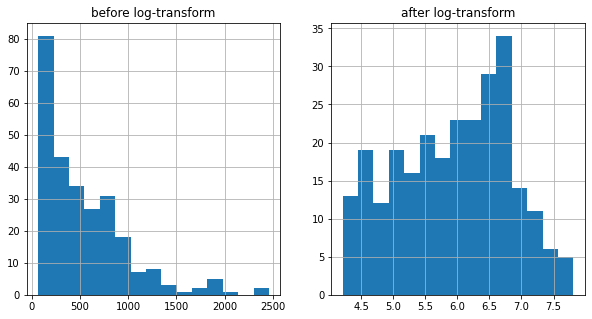

In [7]:
# salary log transform
salary_log = np.log(hitters.Salary)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(x = hitters.Salary, bins=15)
ax[0].set_title('before log-transform')
ax[0].grid()
ax[1].hist(x = salary_log, bins=15)
ax[1].set_title('after log-transform')
ax[1].grid()

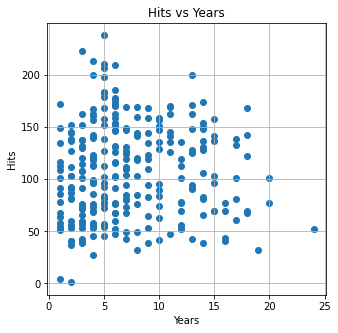

In [8]:
plt.figure(figsize=(5,5))
plt.scatter(hitters.Years, hitters.Hits)
plt.title('Hits vs Years')
plt.xlabel('Years')
plt.ylabel('Hits')
plt.grid()

###  Recursice binary splitting

In [9]:
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [10]:
hitters_num = hitters.loc[:,hitters.dtypes == 'int64']

In [94]:
def find_s(x_in, y_ref, s):
    """
    Function determines 's' parameter for indicidual predictor by minimization of RSS.
    """
    RSS_min = np.inf
    s_min = min(s)
    for i in s:
        R1_ind = np.argwhere(x_in<i)
        R2_ind = np.argwhere(x_in>=i)
        R1_mean = np.average(y_ref[R1_ind])
        R2_mean = np.average(y_ref[R2_ind])
        R1_RSS = sum((x_in[R1_ind]-R1_mean)**2)
        R2_RSS = sum((x_in[R2_ind]-R2_mean)**2)
        RSS_s = R1_RSS + R2_RSS
        if RSS_s<RSS_min:
            RSS_min = RSS_s
            s_min = i
    return RSS_min, s_min


def split(x_in, y_ref, s_partitions):
    """
    Function finds split parameters for individual split according to recursice binary splitting method.
    x_in: pandas dataframe of input predictors
    y_ref: pandas series of reference responses
    s_partitions: number of partition between min and max predicor values when searching for minimum s value for individual predictor.
    
    return: index of predictor with min RSS, s_value for predictor with min RSS.
    """
    pred_list = list(x_in.columns)
    ref = np.array(y_ref)
    RSS_min = []
    s_min = []
    for i in pred_list:
        d_series = np.array(x_in[i])
        s_values = np.linspace(min(d_series), max(d_series),s_partitions)[1:-1] # s values for individual predictor
        RSS_, s_ = find_s(d_series, ref, s_values)
        RSS_min.append(RSS_)
        s_min.append(s_)
    min_ind = np.argmin(RSS_min)
    pred_min = pred_list[min_ind]
    s_min = s_min[min_ind]
    return pred_min, s_min


def initial(x_in):
    predictors = list(x_in.columns)
    R_dict = {}
    for i in predictors:
        R_dict[i] = [min(x_in[i]),max(x_in[i])]
    return R_dict

# ne dela še
def decision_tree(x_in, y_ref, s_partitions, R_size_max):
    R_list = {'R0': initial(x_in)}
    R_x_data = {'R0':x_in}
    R_x_temp = R_x_data.copy()
    R_y_data = {'R0':y_ref}
    predictors = list(x_in.columns)
    R_size=np.inf
    name_ = 0
    while R_size > R_size_max:
        sizes=[]
        for j, i in enumerate(R_x_temp):
            #print(j,i)
            if R_x_data[i].shape[0]>R_size_max:
                pred_, s_ = split(R_x_data[i], R_y_data[i], s_partitions=s_partitions)
                old = R_list[i][pred_].copy()
                name_+=1
                R_list[f'R{name_}'] = R_list[i].copy()
                R_list[f'R{name_}'][pred_] = [s_, old[1]]
                mask_1 = list(((R_x_data[i][pred_]>=R_list[f'R{name_}'][pred_][0]) & (R_x_data[i][pred_]<=R_list[f'R{name_}'][pred_][1])))
                R_x_data[f'R{name_}'] = R_x_data[i][mask_1]
                R_y_data[f'R{name_}'] = R_y_data[i][mask_1]
                size_0 = R_x_data[f'R{name_}'].shape[0]
                if size_0 == 0:
                    del R_x_data[f'R{name_}']
                    del R_y_data[f'R{name_}']
                else:
                    sizes.append(size_0)
                name_+=1
                R_list[f'R{name_}'] = R_list[i].copy()
                R_list[f'R{name_}'][pred_] = [old[0],s_]
                mask_2 = list(((R_x_data[i][pred_]>=R_list[f'R{name_}'][pred_][0]) & (R_x_data[i][pred_]<R_list[f'R{name_}'][pred_][1])))
                R_x_data[f'R{name_}'] = R_x_data[i][mask_2]
                R_y_data[f'R{name_}'] = R_y_data[i][mask_2]
                size_1 = R_x_data[f'R{name_}'].shape[0]
                if size_1 ==0:
                    del R_x_data[f'R{name_}']
                    del R_y_data[f'R{name_}']
                else:
                    sizes.append(size_1)
                del R_list[i]
                del R_x_data[i]
                del R_y_data[i]
            else:
                sizes.append(R_x_data[i].shape[0])
                pass
        R_x_temp = R_x_data.copy()
        R_size=max(sizes)
        #print(list(R_list.keys()), sizes, sum(sizes))
        #print('-----------------------------------------')
    #print(R_list)
    Y_outputs = {}
    for j in R_list:
        Y_outputs[j] = np.average(R_y_data[j])
    
    return R_list, Y_outputs

In [145]:
def predict(input_, R_list, y_ref):
    predictors = list(input_.index)
    for i in list(R_list.keys()):
        bool_list = []
        for j in predictors:
            if (input_[j] > R_list[i][j][0]) & (input_[j] < R_list[i][j][1]):
                bool_list.append(1)
            else:
                bool_list.append(0)
        if np.array(bool_list).all() == True:
            return y_ref[i]

In [212]:
ind = 1
pred_data = hitters_num.loc[ind]
x_data = {50:[], 30:[], 10:[]}
errors = {50:[], 30:[], 10:[]}
predictions = {50:[], 30:[], 10:[]}
refs = {50:[], 30:[], 10:[]}
print(sizes)
for r_size in [50, 30, 10]:
    my_tree, y_ref_vals = decision_tree(hitters_num, hitters.Salary, s_partitions=30, R_size_max=r_size)
    for i in hitters_num.index:
        ref_y = hitters.loc[i].Salary
        y_pred = predict(hitters_num.loc[i,:], my_tree, y_ref_vals)
        if y_pred is None:
            pass
        else:
            dif = abs(ref_y - y_pred)
            errors[r_size].append(dif)
            x_data[r_size].append(i)
            predictions[r_size].append(y_pred)
            refs[r_size].append(ref_y)

[50 45 40 35 30 25 20 15 10]


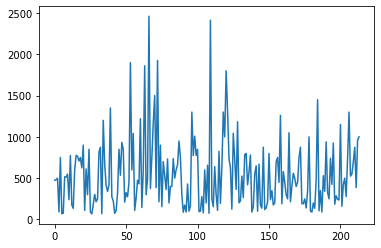

In [213]:
plt.plot(refs[50])

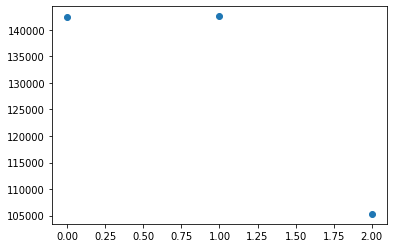

In [222]:
plt.plot((ms.MSE(np.array(predictions[50]), np.array(refs[50])),ms.MSE(np.array(predictions[30]), np.array(refs[30])),ms.MSE(np.array(predictions[10]), np.array(refs[10]))),'o')

(0.0, 100.0)

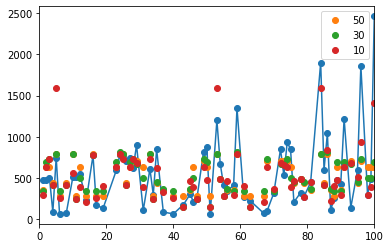

In [263]:
plt.plot(x_data[50], refs[50],'-o')
plt.plot(x_data[50], predictions[50],'o', label=50)
plt.plot(x_data[30], predictions[30], 'o', label=30)
plt.plot(x_data[10], predictions[10], 'o', label=10)
plt.legend()
plt.xlim(0,100)

##### Decision trees using sklearn

In [223]:
reg_tree = tree.DecisionTreeRegressor()

In [231]:
reg_tree_fit = reg_tree.fit(hitters_num, hitters.Salary)

In [235]:
sklearn_pred = reg_tree_fit.predict(hitters_num)


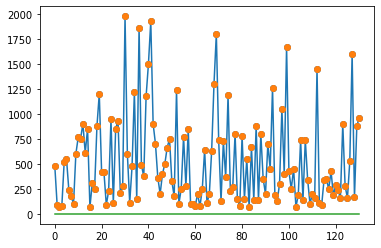

In [232]:
plt.plot(np.arange(131), reg_tree_fit.predict(hitters_num[1::2]),'-o')
plt.plot(np.arange(131),hitters.Salary[1::2],'o')
plt.plot(np.arange(131), reg_tree_fit.predict(hitters_num[1::2])- hitters.Salary[1::2])

In [236]:
(ms.MSE(np.array(predictions[50]), np.array(refs[50])),ms.MSE(np.array(predictions[30]), np.array(refs[30])),ms.MSE(np.array(predictions[10]), np.array(refs[10])))

(142441.44243009764, 142559.52950642162, 105315.57744960418)

In [228]:
reg_tree_fit.predict(hitters_num[1::2]).shape

(131,)

In [229]:
hitters_num[1::2].shape

(131, 16)

In [230]:
hitters.Salary[1::2].shape

(131,)